## Dacon  14회 스미싱 문자 모델링 경진대회
## 팀명 : 스팸구이
### 작성일 : 2020.02.29
고전 NLP 방법에서 제일 대표적인 방법인 Bag of Words 쪽으로 전처리부터 학습, 예측까지 분류문제를 풀었습니다.  
우선적으로 스폰서의 요청에 따라 똑같이 올릴 수 없기 때문에 저희가 제출한 코드와 완벽하게 똑같지는 않습니다.   
하지만 저희가 시도하던 컨셉은 유사하니 참고하시면 될 것 같습니다.  
그리고 도움될만한 공부자료들도 링크를 달아놨습니다.   

**Contents**
1. Library & Load Data
2. Data Cleansing & Pre-Processing
3. Morphology Analysis
4. TF-IDF
5. LightGBM Training
6. Prediction & Submission
7. LIME(Local Interpretable Model-agnostic Explanations)

## 1. Library & Load Data

In [1]:
import os
import sys
from time import time
import re
import pandas as pd 
import numpy as np 
import random 

from IPython.display import Image
from collections import Counter
from tqdm import tqdm 
from pandas import DataFrame 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [2]:
train = pd.read_csv("./train.csv")

train.head(2)

,id,year_month,text,smishing
0,0,2017-01,XXX은행성산XXX팀장입니다.행복한주말되세요,0
1,1,2017-01,오늘도많이웃으시는하루시작하세요XXX은행 진월동VIP라운지 XXX올림,0


In [3]:
test = pd.read_csv("./public_test.csv")

test.head(2)

,id,year_month,text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...


In [4]:
print(train.shape)
print(test.shape)

(295945, 4)
(1626, 3)


In [5]:
train['smishing'].value_counts()

0    277242
1     18703
Name: smishing, dtype: int64

## 2. Data Cleansing & Pre-Processing
제공되는 데이터에는 개인정보보호를 위해 개인정보로 간주될 수 있는 이름, 전화번호, 은행 이름, 지점명 XXX로 Masking이 되어있습니다.  
단어 빈도를 중요시 여기는 Bag-of-Words 기반 방법으로 접근함에 있어서 이는 모델에 악영향을 줄 수 있습니다.

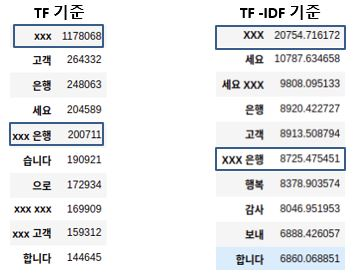

In [6]:
Image('dacon14_images/1_TF.JPG')

위의 표는 상위 10개단어입니다. 그림과 같이 XXX단어가 117만번 나타났습니다.XXX 단어가 압도적으로 많기때문에 이를 분산시키거나, 스케일을 조정할 필요가 있습니다.   
따라서 다음 예시처럼 치환하는 전처리의 필요성을 느꼈습니다.

In [7]:
example_word_replace_list = {'XXX고객' : '홍길동 고객',
                     'XXX 고객' : '홍길동 고객',
                     'XXX은행' : 'kb 은행',
                     'XXX올림' : '직원 올림',
                     'XXX' : '아무개'}

word_replace_list는 실제로 더 많은 단어(은행이름, 지점명 등)들을 바꾸었습니다. 자체적으로 실제 dictionary 형태의 데이터를 만들었습니다.  

In [8]:
# text 변수부분만 데려와 치환하는 Util Function를 만듭니다.
def apply_replacement(src_df, replace_func):
    ret_df = src_df
    ret_df['text'] = ret_df['text'].apply(lambda x: replace_func(x))
    return ret_df

In [9]:
%%time
def word_replace(x):
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

train = apply_replacement(train, word_replace)
test = apply_replacement(test, word_replace)

Wall time: 956 ms


전화번호, 계좌번호, 특수문자 들도 처리를 해줍니다.

In [10]:
%%time
def replace_ph_ba(sentence):
    
    sentence = re.sub('([x|X]{2,3}-[x|X]{3,4}-[x|X]{3,4})', 'TEL' , sentence)
    sentence = re.sub('(X{3,6}-X{2,6}-X{2,7})(-X{1,6})?', 'ACCOUNT', sentence)
    return sentence
    
train = apply_replacement(train, replace_ph_ba)
test = apply_replacement(test, replace_ph_ba)

Wall time: 2.64 s


In [11]:
%%time
def remove_special_sysmbols(sentence): 
    sentence = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', sentence)
    return sentence

train = apply_replacement(train, remove_special_sysmbols)
test = apply_replacement(test, remove_special_sysmbols)

Wall time: 1.53 s


대회 제일 처음에 제공했던 baseline code에서 일부 데이터만을 활용하고, under sampling하는 내용이 있었습니다.  
저희는 baseline code에서 1, 0의 비율을 반영하는 대신, label이 1인 데이터들은 전부 활용하기로 했습니다.

In [12]:
random.seed(4321) 

train_nsm_list=list(train[train['smishing']!=1].index)

train_nsmishing=random.sample(train_nsm_list, 275044) 

 

random.seed(4321)

train_sm_list=list(train[train['smishing']==1].index)

train_smishing=random.sample(train_sm_list, 18703) 

In [13]:
train_xx=train.iloc[train_smishing+train_nsmishing,:].reset_index(drop=True)

train_yy=DataFrame(train['smishing'],columns=['smishing']) 
train_yyy=train_yy.iloc[train_smishing+train_nsmishing,:].reset_index(drop=True)

In [14]:
test['smishing']=2
test_xx=DataFrame(test['text'])
test_yyy=DataFrame(test['smishing'])

## 3. Morphology Analysis
  
mecab 형태소 분석기는 성능도 좋고 속도측면에서 다른 형태소 분석기들에 비해 상당히 뛰어나다고 알려져 있습니다.  
이번 Competition에서는 Auc로 평가하지만 비중이 70%를 차지하며, Inference time 30%을 차지하고 있기 때문에, 전처리 시간도 중요합니다. 

작성자의 개발환경은 window이기 때문에 konlpy의 여러 형태소 분석기들 중에서 mecab을 활용할 수 없습니다.
하지만 **[code cleaner](https://cleancode-ws.tistory.com/97)** 글을 참고하면 window 유저들도 mecab을 빌드하여 활용할 수 있습니다.     

In [15]:
import MeCab
import re

mecab = MeCab.Tagger()

def mecab_morphs(text):
    morphs = []
    
    pattern = re.compile(".*\t[A-Z]+") 
    
    # konlpy의 mecab output 형태와 같게 만들어주기
    temp = [tuple(pattern.match(token).group(0).split("\t")) for token in mecab.parse(text).splitlines()[:-1]]
        
    for token in temp:
        morphs.append(token[0])
    
    return morphs

In [16]:
train_doc = [(mecab_morphs(x), y) for x, y in tqdm(zip( train_xx['text'], train_yyy['smishing']))]
test_doc = [(mecab_morphs(x), y) for x, y in tqdm(zip( test_xx['text'], test_yyy['smishing']))]

293747it [01:41, 2885.74it/s]
1626it [00:00, 1723.27it/s]


Mac을 쓰시는 유저분들은 다음과 같이 작성하시면 됩니다.

In [17]:
# from konlpy.tag import Mecab
# mecab = Mecab()
# train_doc = [(mecab.morphs(x),y) for x,y in zip(train_xx['text'],train_yyy['smishing'])]
# test_doc = [( mecab.morphs(x),y) for x,y in zip(test_xx['text'],test_yyy['smishing'])]

TF-IDF vectorizer를 적용하기 위해 마지막 전처리 작업을 수행합니다.  
일부 불용어도 제거하며, 조사와 1글자 단어들도 제거합니다.

In [18]:
stopwords = ['을', '를', '이', '가', 'ㅡ', '은', '는', 'XXX'] 

def get_model_input(_words): #필요없는 단어들 없애는 함수
    global stopwords
    _words = [x for x in _words if x[0] not in stopwords]
    _words = [x for x in _words if x[:-1] not in stopwords]

    for i in range(len(_words)-1):
        yield _words[i]      

In [19]:
%%time
X_train, Y_train = [], []
for lwords in train_doc:
    Y_train.append(lwords[1])
    
    temp = []
    for x in get_model_input(lwords[0]):
        if len(x) != 1:
            temp.append("{}".format(x))
    X_train.append(" ".join(temp))

Wall time: 19.6 s


In [20]:
%%time
X_test = []
for lwords in test_doc:
    
    temp = []
    for x in get_model_input(lwords[0]):
        if len(x) != 1:
            temp.append("{}".format(x))
    X_test.append(" ".join(temp))

Wall time: 210 ms


다음과 같이 전처리되어 결과가 나타납니다.

In [21]:
X_train[1234]

'광고 한국 아무개 bank 대출 한도 금리 자신 모르 사이 악성 과다 빠져 허덕이 다면 문자 집중 감사 드리 습니다 여러분 악성 과다 상환 도록 포토 리어 작성 동의 진행 시켜 드릴 껍니다 대출 50 금융 신분 월급 절반 정도 카드 으로 빠지 부채 대부분 원리금 방식 으로 상환 등급 대출 된다고 판단 사용 대출 금리 다이어트 고자 내용 한건 라도 해당 신다면 상담 필요 다고 생각 듭니다 저희 모든 수단 방법 동원 금리 최대한 낮춰 드리 금융 관한 지식 알려 드리 습니다 한국 citi bank 직장 상품 금리 282 CD 금리 변동 직장 기준 공무원 외감 업체 기업 우대 한도 천만 까지 일반 업체 개인사 업장 근로자 진행 신용 도와 상관없이 자체 등급 으로 판단 상담 신청 방법 문자 상담 라고 답장 거나 전화 정직 친절히 상담 으로 도움 드릴께요 신용 상담 위한 신용 조회 등급 영향 미치 습니다 카카오톡 신청 방법 IDcitibank 12 아이디 검색 친구 추가 상담 라는 카톡 남겨 세요 빠르 답변 드리 습니다 부채 통합 대출 상품 자격 조건 보험 직장 and 재직 미만 직군 등급 따라 습니다 한도 연봉 대비 300 까지 금리 최저 등급 차등 적용 부채 통합 대출 장점 최대 85 정도 절감 100 신용 등급 상승 최대 13 등급 까지 상향 연봉 대비 DTI 280 까지 직군 소득 차등 적용 건수 최소 시켜 관리 용이 추가 자금 까지 저금리 확보 드립니다 신청 방법 문자 FW'

## 4. TF-IDF
행에는 스미싱 문자들의 정보, 열에는 용어 정보가 나열되고 개별 문자에서 발생한 용어의 발생 빈도를 원소로 하는 행렬을 **DTM(Document-Term frequency Matrix)**이라고 부릅니다.  

하지만 DTM의 용어들의 빈도만을 가지고 문자들의 차별성과 용어들의 중요도를 반영하기 어려워 대중적으로 많이 사용하는 용어 가중치인 TF-IDF를 적용합니다.  
저희가 사용할 Feature들로는 uni-gram, bi-gram, tri-gram 모두 활용하였습니다.  

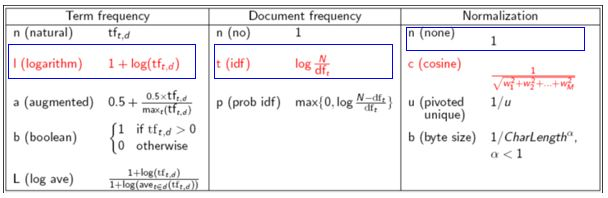

In [22]:
Image('dacon14_images/2_Weighting_table.JPG')

그리고 위의 표와 같이 TF-IDF의 변형된 가중치들이 매우 많습니다.  
파란색 블록으로 쳐져있는 것이 여기 코드에 적용된 것이고, 빨간색으로 쓰여진 부분이 많이 활용되고 있다고 합니다.(표 [출처](https://imgur.com/cTYKdhr))   
사이킷런에서 TfidfVectorizer를 활용하는데 sublinear_tf 옵션에 True로 지정하면 TF(Term Frequency)의 영향을 줄이기 위해 1+log(TF)를 사용할 수 있습니다.  


더 좋은 참고 자료는 **[youtube todaycode오늘코드](https://youtu.be/RPGuYIGGKKM)** 영상을 참고하시면 공부하는데 도움이 됩니다.  

In [23]:
vectorizer=TfidfVectorizer(ngram_range=(1, 3),
    min_df=2,   
    max_features=10000,
    sublinear_tf=True,
    lowercase=False,
    use_idf=True) 

In [24]:
%%time
vec_x_train= vectorizer.fit_transform(X_train)
vec_x_test= vectorizer.transform(X_test)

Wall time: 48.9 s


## 5.LightGBM Training
저는 따로 class가 imbalance하다고 해서 resampling을 활용하지 않았습니다.(6%로도 충분히 감사했습니다.)    
층화추출을 따로 실시하여 자체적으로 validation set을 만들었습니다. 그리고 baseline model을 정하기위해 머신러닝 기법을 여러개 다루어보았습니다.(Linear Model, Tree Based Model etc.)  
적용한 기법들은 다음과 같습니다.  
1. Logistic Reg  
2. SVM (Linear Kernal)   
3. Ridge Classifier   
4. Multinomial NB   
5. Bernoulli NB  
6. MLP  
7. AdaBoost  
8. RandomForest  
9. GBM  
10. XgBoost   
11. LightGBM  

위의 기법들을 적용할 때 튜닝 값은 거의 Rough하게 잡고 시행했습니다. TF-IDF를 적용하고 대부분의 기법들이 성능이 다 비슷비슷했습니다.     
특히 SVM, LightGBM 2개가 성능이 상당히 좋았었는데, 예전에 공부하면서 오래전 이야기이지만, Linear Kernel의 SVM이 Text Classification Task 중에 Sparse Data case에 대해 성능이 좋다는 내용을 공부를 했었습니다.(Hornik, K. Meyer, D. and Karatzoglou, A. (2006). Support vector machines in R. Journal of Statisticcal Software, 15, 1-28.)   

하지만 학습시간이랑 예측하는 속도를 비교했을 때 LightGBM으로 진행하는것이 좋다고 판단했습니다.  

튜닝 가이드 라인은 Parameter는 Grid Search를 실시하여 n_estimators, learning_rate, min_child_samples, max_depth 들의 큰 틀을 잡았습니다. L1, L2 regularization은 사용하지 않았습니다.  
세부적인 튜닝의 우선 순위는 다음과 같고 아래의 수치들은 최적화된 hyperparameter입니다.  
1. n_estimators
2. learning_rate
3. min_child_samples
4. max_depth

In [25]:
%%time
lgbm = LGBMClassifier(n_estimators=380,
                     learning_rate=0.035,
                     max_depth=7,
                     min_child_samples=50,
                     random_state=4321)
lgbm.fit(vec_x_train, Y_train)

Wall time: 2min 25s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.035, max_depth=7,
               min_child_samples=50, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=380, n_jobs=-1, num_leaves=31, objective=None,
               random_state=4321, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## 6. Prediction & Submission
다음과 같이 제출파일을 작성합니다.

In [26]:
%%time
y_train_pred1=lgbm.predict_proba(vec_x_train)
y_train_pred1_one= [ i[1]  for i in y_train_pred1]

y_test_pred1=lgbm.predict_proba(vec_x_test)
y_test_pred1_one= [ i[1]  for i in y_test_pred1]

Wall time: 1.96 s


In [27]:
submission = pd.DataFrame(
{"id" : test.id,
"smishing" : y_test_pred1_one})
submission.head()

,id,smishing
0,340000,1.588909e-07
1,340001,4.914419e-07
2,340002,1.168460e-07
3,340003,1.721641e-07
4,340004,1.216290e-07


In [28]:
submission.to_csv("Thank_you_for_the_dacon.csv", index = False)

## 7. LIME(Local Interpretable Model-agnostic Explanations)
XAI(eXplainable-AI)의 방법 중 대표적인 LIME을 한번 적용해보겠습니다.  
LIME을 공부하는데 좋은 도움이 될 자료들을 소개합니다.  

1. LIME의 컨셉을 간단히 익히고 [싶으신 분들](https://dreamgonfly.github.io/2017/11/05/LIME.html)  
2. 정석으로 공부하시고 [싶으신 분들](https://christophm.github.io/interpretable-ml-book/)  
3. 다양하게 튜토리얼로 구현해보고 [싶으신 분들](https://github.com/marcotcr/lime/tree/ce2db6f20f47c3330beb107bb17fd25840ca4606) 

예측한 데이터 샘플을 바탕으로 구현해보면 다음과 같습니다.  
참고한 튜토리얼은 [다음](https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html)과 같습니다.  

In [29]:
from lime import lime_text
from sklearn.pipeline import make_pipeline
c = make_pipeline(vectorizer, lgbm)

In [30]:
class_names = ['non-smishing', 'smishing']
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [31]:
idx = 297
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Probability(smishing) =', c.predict_proba([X_test[idx]])[0,1])
# exp.show_in_notebook(text=True)

Document id: 297
Probability(smishing) = 0.9999945382889718


In [32]:
idx = 298
exp = explainer.explain_instance(X_test[idx], c.predict_proba, num_features=10)
print('Document id: %d' % idx)
print('Probability(smishing) =', c.predict_proba([X_test[idx]])[0,1])
# exp.show_in_notebook(text=True)

Document id: 298
Probability(smishing) = 3.558990155032273e-06


exp.show_in_notebook(text=True)를 실시하면 다음과 같이 나타납니다.

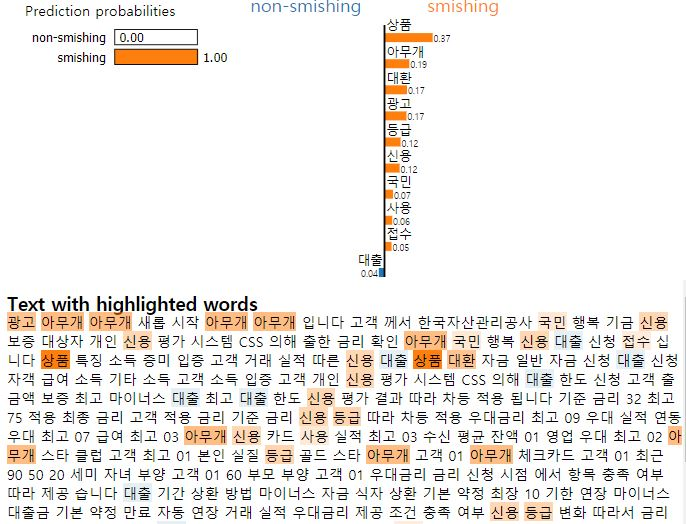

In [33]:
Image('dacon14_images/3_Smishing_Case.JPG')

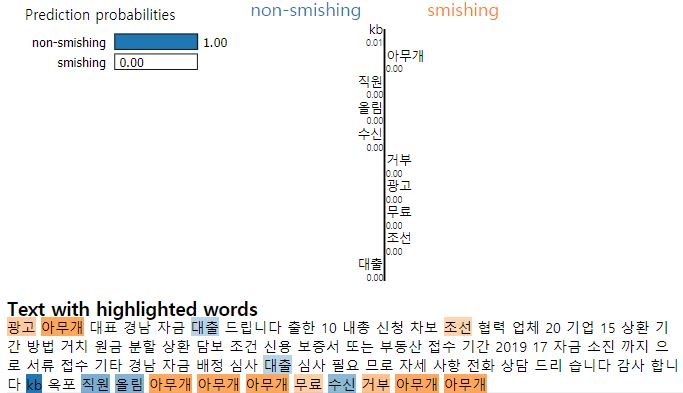

In [34]:
Image('dacon14_images/4_NonSmishing_Case.JPG')